In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt

import holidays
import networkx as nx
import scipy
from scipy.linalg import eig
from scipy.stats import kstest

from constants import (
    MAX_TAXI_ZONE_ID,
    location_ids,
    excluded_location_ids,
    location_id_to_index,
    num_locations,
    taxi_type,
    YEARS,
    MONTHS
)


# The goal of this notebook is to go through NYC FHVHV trip data to learn:

- time-varying rider arrival rates, $\lambda_{ij}(t)$
- time-varying trip completion rates, $\mu_{ij}(t)$
- rider transition matrices, $P_{ij}$

## Initialization / Preprocessing

In [ ]:
Delta = 20 # in minutes
T_max = int(24 * (60 // Delta))

us_holidays = holidays.US(years=YEARS)

## $P_{ij}$

In [4]:
# # Create an empty 3D array
# trip_counts = np.zeros((int(24 / (Delta / 60)), num_locations, num_locations), dtype=int)
# num_dates = 0

# for year, month in tqdm(itertools.product(YEARS, MONTHS)):
#     df = pd.read_parquet(f'data/{taxi_type}_tripdata_{year}-{month}.parquet')
    
#     unique_dates = df.pickup_datetime.dt.date.unique()
#     working_days = [date for date in unique_dates if date.weekday() < 5 and date not in us_holidays]
#     num_dates += len(working_days)
    
#     # Filter for weekdays that are NOT US holidays
#     df = df[
#         (df.pickup_datetime.dt.weekday < 5) &  # Monday to Friday
#         (~df.pickup_datetime.dt.date.isin(us_holidays))  # Exclude US holidays
#     ]

#     # filter for valid locatino IDs
#     df = df[df['PULocationID'].isin(location_ids) & df['DOLocationID'].isin(location_ids)]
#     df['time_bin'] = (df['pickup_datetime'].dt.hour * (60 // Delta) + df['pickup_datetime'].dt.minute // Delta).astype(int)
    
#     # Map IDs to array indices
#     df['pu_idx'] = df['PULocationID'].map(location_id_to_index)
#     df['do_idx'] = df['DOLocationID'].map(location_id_to_index)

#     # Group by all 3 axes
#     grouped = df.groupby(['time_bin', 'pu_idx', 'do_idx']).size()

#     # Fill in the counts using multi-index
#     trip_counts[grouped.index.get_level_values(0),
#                 grouped.index.get_level_values(1),
#                 grouped.index.get_level_values(2)] += grouped.values

# # Save trip_counts to a file
# np.savez_compressed('trip_counts.npz', trip_counts=trip_counts, num_dates=num_dates)

# read the trip_counts from the file

with np.load('trip_counts.npz') as data:
    trip_counts = data['trip_counts']
    num_dates = data['num_dates']

### Check positive recurrence of the Markov chain for each time period

- Check irreducibility
- Check positive recurrence by calculating stationary distribution

In [5]:
missing_trips = np.argwhere(trip_counts == 0)

len(missing_trips) / np.prod(trip_counts.shape) * 100

np.float64(14.461923444494742)

In [6]:
result = []

for t in range(T_max):
    P = trip_counts[t] / trip_counts[t].sum(axis=1, keepdims=True)  # Normalize rows to sum to 1
    G = nx.DiGraph(P > 0)  # adjacency matrix where there's a transition
    is_irreducible = nx.is_strongly_connected(G)
    if is_irreducible:
        # solve for stationary distribution
        vals, vecs = eig(P.T, left=True, right=False)
        i = np.argmin(np.abs(vals - 1))
        pi = np.real(vecs[:, i])
        pi = pi / pi.sum()  # Normalize to sum to 1

        is_positive_recurrent = np.all(pi > 0)
        result.append(is_positive_recurrent)
    else:
        result.append(False)
        
print(f"All time bins are {'irreducible' if all(result) else 'not irreducible'}")

All time bins are irreducible


## Compute $\mu_{ij}$

In [7]:
# # some data structure to save
# d = defaultdict(list)

# for year, month in tqdm(itertools.product(YEARS, MONTHS)):
#     df = pd.read_parquet(f'data/{taxi_type}_tripdata_{year}-{month}.parquet')
    
#     # Filter for weekdays that are NOT US holidays
#     df = df[
#         (df.pickup_datetime.dt.weekday < 5) &  # Monday to Friday
#         (~df.pickup_datetime.dt.date.isin(us_holidays))  # Exclude US holidays
#     ]

#     # filter for valid locatino IDs
#     df = df[df['PULocationID'].isin(location_ids) & df['DOLocationID'].isin(location_ids)]
#     df['time_bin'] = (df['pickup_datetime'].dt.hour * (60 // Delta) + df['pickup_datetime'].dt.minute // Delta).astype(int)
    
#     # Map IDs to array indices
#     df['pu_idx'] = df['PULocationID'].map(location_id_to_index)
#     df['do_idx'] = df['DOLocationID'].map(location_id_to_index)
    
#     # # groupby is too slow
#     # for (t, pu, do), group in df.groupby(['time_bin', 'pu_idx', 'do_idx']):
#     #     d[(t, pu, do)].extend(group['trip_time'].values)
    
#     # Step 1: Create a combined key as a structured array
#     keys = df[['time_bin', 'pu_idx', 'do_idx']].to_records(index=False)

#     # Step 2: Sort by key to enable fast grouping
#     sorted_indices = np.argsort(keys, order=('time_bin', 'pu_idx', 'do_idx'))
#     df_sorted = df.iloc[sorted_indices].reset_index(drop=True)

#     # Step 3: Create the same key array from sorted df
#     sorted_keys = df_sorted[['time_bin', 'pu_idx', 'do_idx']].to_records(index=False)

#     # Step 4: Find group boundaries
#     unique_keys, start_indices, counts = np.unique(sorted_keys, return_index=True, return_counts=True)
    
#     # Step 6: Slice the trip_time column efficiently
#     trip_times = df_sorted['trip_time'].to_numpy()
    
#     for key, start, count in zip(unique_keys, start_indices, counts):
#         d[(key.time_bin, key.pu_idx, key.do_idx)].extend(trip_times[start:start + count])
        
# # Flatten
# keys = []
# counts = []
# trip_time_chunks = []

# for key, arr in tqdm(d.items()):
#     keys.append(key)
#     counts.append(len(arr))
#     trip_time_chunks.append(arr)

# # Concatenate all trip times into one big array
# all_trip_times = np.concatenate(trip_time_chunks)

# # Create key_counts array: (time_bin, pu_idx, do_idx, count)
# key_counts = np.array([
#     (*k, c) for k, c in zip(keys, counts)
# ], dtype=np.int32)

# # Save efficiently
# np.save('all_trip_times.npy', all_trip_times)
# np.save('key_counts.npy', key_counts)


Load `d`

In [8]:
# Load from files
all_trip_times = np.load('all_trip_times.npy')
key_counts = np.load('key_counts.npy')  # shape = (num_keys, 4)

# Reconstruct the dictionary
d = defaultdict(list)
start = 0

for row in tqdm(key_counts):
    t, pu, do, count = row
    d[(t, pu, do)] = all_trip_times[start:start + count]
    start += count


  0%|          | 0/3401165 [00:00<?, ?it/s]

Check distribution match of trip completion times (K-S Test, Visualization)

In [9]:
# Find (time, pickup, dropoff) with the most trips

lengths = [(key, len(x)) for key, x in d.items() if len(x) > 0]
lengths.sort(key=lambda x: x[1], reverse=True)

# This is 8:00am - 8:20am from Crown Heights South, Brooklyn to Crown Heights South, Brooklyn. (but why though?)

travel_times = np.array(d[lengths[1][0]])
lambda_hat = 1.0 / travel_times.mean()
D, p_value = kstest(
    rvs=travel_times, 
    cdf='expon', 
    args=(140, 345), #  (loc, scale)
    alternative='two-sided',
)

print(f"p-value of K-S Test: {p_value}")

p-value of K-S Test: 0.0


In [10]:
# Filter for travel times above 99.9 percentile and below 0.01 percentile
# This is to remove outliers (some trips are 1 second long, some trips are like 1 hour)

upper_threshold = np.quantile(travel_times, 0.999)
lower_threshold = np.quantile(travel_times, 0.001)
travel_times_filtered = travel_times[(travel_times > lower_threshold) & (travel_times < upper_threshold)]

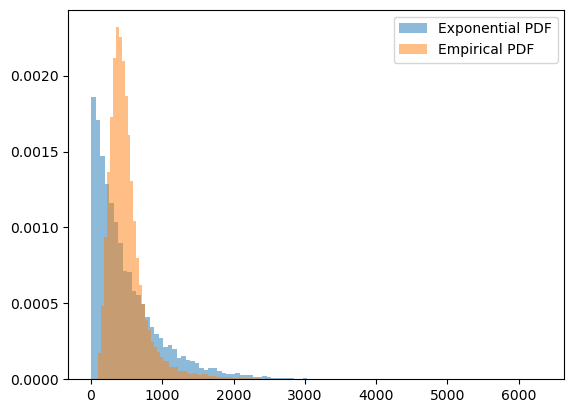

In [11]:
# Visualize the distribution mismatch between the empirical data and the fitted distribution

loc, scale = scipy.stats.expon.fit(travel_times_filtered, floc=0)
samples = np.random.exponential(scale=scale, size=10000) + loc
plt.hist(samples, bins=100, density=True, alpha=0.5, label='Exponential PDF')
plt.hist(travel_times_filtered, bins=100, density=True, alpha=0.5, label='Empirical PDF')
plt.legend()
plt.show()

Problem 1: Distribution mismatch with exponential distribution

Solution: Ignore it for now lmao, assume it is exponential.


Problem 2: Missing entries (i.e. data is still too sparse), so we don't know $\mu_{ij}^{(t)}$ for some $i,j,t$ triplet.

Patch: Taking moving windows average (moving on time), or kernel smoothing over time. Think about smarter matrix completion later.

In [12]:
# mu_ = np.empty((int(24 / (Delta / 60)), num_locations, num_locations))
# mu_[:] = np.nan

# for key, arr in tqdm(d.items()):
#     time_bin, pu_idx, do_idx = key
#     if np.mean(arr) == 0:
#         continue
#     mu_[time_bin, pu_idx, do_idx] = 1 / np.mean(arr)
# np.savez_compressed('mu.npz', mu=mu_)

In [13]:
with np.load('mu.npz') as data:
    mu = data['mu']

## Compute $\lambda_{ij}$

The number of arrivals $N_{it}^{(d)}$ on day $d$, for time bin $t$, at location $i$, is assumed to be distributed as:
$$N_{it}^{(d)} \sim \text{Poisson}(\lambda_{it}\cdot \Delta)$$

MLE for $\lambda_{it}$, per-hour rider arrival rate, is: $$\hat{\lambda}_{it} = \frac{1}{D\cdot (\Delta / 60)}\sum_{d=1}^D \sum_{j=1}^r N_{ijt}^{(d)}$$ where $D$ is the number of observed working days, and $\Delta$ is the time bin width in minutes, and $j$ is the destination location.

In [14]:
lambda_ = trip_counts.sum(axis=2) / (Delta / 60 * num_dates)

Check if $\lambda_{it} > 0$ for all $i$ and $t$.

In [15]:

zero_lambda_indices = np.argwhere(lambda_ == 0)
print(f"There are {len(zero_lambda_indices)} number of location/time pair(s) with zero arrival rate")

There are 0 number of location/time pair(s) with zero arrival rate
